import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# added to be able to run in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')

import utils

In [3]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
import json
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import random

from skimage.filters import threshold_otsu

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
1.13.0+cu116


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 11 16:55:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [5]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'generalizedDet_finetuned_2023_01_10_T1T2T3_forExp2'

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 50
weight_reg = 2.0    # balances regression loss with segmentation loss. Value chosen based on past investigation.
weight_background = 0.1   # for regression loss only, downweights background pixels to highlight foreground pollen

#model parameters
batch_size = 4
newSize = [800,800] # set to crop size, to tell model what size tensor to expect
total_epoch_num = 120  # total number of epoch in training
base_lr =0.0005        #0.0005      # base learning rate/
scaleList = [0]      # the number of output layer for U-net
#scale = [0,1,2,3]      # the number of output layer for U-net


exp_dir = '/content/gdrive/MyDrive/exp/final' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

cuda:0


In [6]:
path_to_image = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999'
with open(os.path.join(save_dir,'dbinfo.plk'), 'rb') as handle:
    dbinfo = pickle.load(handle)    
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list']), 720, 180)

In [7]:
set_name='train'
sampleList = dbinfo[set_name+'_det_list']
idx = 2

path_to_image = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999'

current_example= sampleList[idx]
current_image_path= os.path.join(path_to_image, current_example[0], current_example[0] + '_tiles_withAnnot', current_example[1], current_example[2])

all_points = []
all_radii = []
for file in os.listdir(current_image_path):
  if file.endswith('.json'):
      with open(os.path.join(current_image_path, file), "r",encoding="utf-8") as f:
          tmpData = json.load(f)            
          for shape in sorted(tmpData["shapes"], key=lambda x: x["label"]):
              # full_annot.append(shape)
              # label_name = shape["label"]
              points = shape['points']
              
              xy = [tuple(point) for point in points]
              (cx, cy), (px, py) = xy
              d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
              all_points.append(xy[0])
              all_radii.append(d)


print(all_points)
print(all_radii)

[(380.8709677419355, 62.67741935483872), (130.8709677419355, 19.129032258064512), (600.2258064516129, 672.3548387096774), (967.9677419354839, 699.7741935483871)]
[100.05201560819887, 128.75979297591633, 106.80537503963424, 100.38946012642212]


/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_masks2/PAL1999_C3_sample43_slide1/40368x_44720y


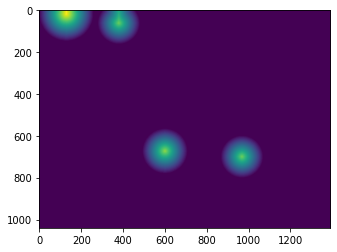

In [8]:
path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999'
current_distTransform_path=os.path.join(path_to_mask, current_example[0], current_example[0] + '_masks2', current_example[1], current_example[2])
print(current_distTransform_path)
for file in os.listdir(current_distTransform_path):
  if file.endswith('.png'):
    mask = Image.open(os.path.join(current_distTransform_path, file))
    mask=np.array(mask)
plt.imshow(mask)

In [9]:
class PollenDet(Dataset):
    def __init__(self, path_to_image='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999',
                #  path_to_annot='/content/gdrive/MyDrive/UTRECHT/Detection/AnnotCombo9_noNPP_circleMask',
                 path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999',
                 dbinfo=dbinfo,
                 size=[1040,1392], 
                 set_name='train'):
        
        self.path_to_image = path_to_image
        # self.path_to_annot = path_to_annot
        self.path_to_mask = path_to_mask
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        self.resizeFactor = size[0]/1000
        
        self.sampleList = self.dbinfo[set_name+'_det_list']

        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        # self.TFresize = transforms.Resize((self.size[0],self.size[1]))

        
        self.TFRandomCrop = transforms.RandomCrop(800)
        # self.TFCrop = transforms.Crop(img, top, left, height, width)
        self.TFHFlip = transforms.RandomHorizontalFlip()

    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        current_example= self.sampleList[idx]

        current_image_path= os.path.join(self.path_to_image, current_example[0], current_example[0] + '_tiles_withAnnot', current_example[1],current_example[2])
        current_distTransform_path=os.path.join(self.path_to_image, current_example[0], current_example[0] + '_masks2', current_example[1],current_example[2])
        # curPickleName = os.path.join(self.path_to_annot, current_example)

        imagestack_array = []
        for file in sorted(os.listdir(current_image_path)):
          if file.endswith('.png'):
            slice = Image.open(os.path.join(current_image_path, file))
            imagestack_array.append(np.asarray(slice))
        image = np.block(imagestack_array)
        if image.shape[2] <27:
          pad_val = 27-image.shape[2]
          npad = ((0, 0), (0,0), (0,pad_val))
          image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

        for file in os.listdir(current_distTransform_path):
          if file.endswith('.png'):
            mask = Image.open(os.path.join(current_distTransform_path, file))
            mask=np.array(mask)

        TP_points = []
        TP_radii = []
        for file in os.listdir(current_image_path):
          if file.endswith('full_annot.plk'):
              with open(os.path.join(current_image_path, file), 'rb') as handle:
                  tmpData = pickle.load(handle) 
                  for shape in tmpData:
                      label_name = shape["label"]
                      points = shape['points']
                      xy = [tuple(point) for point in points]
                      (cx, cy), (px, py) = xy
                      d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
                      TP_points.append(xy[0])
                      TP_radii.append(d)    

        hard_ex_points = []
        for file in os.listdir(current_image_path):
          if file.endswith('hard_examples.plk'):
              with open(os.path.join(current_image_path, file), 'rb') as handle:
                  tmpData = pickle.load(handle) 
                  for shape in tmpData:
                      label_name = shape["label"]
                      points = shape['points']
                      xy = [tuple(point) for point in points]
                      (cx, cy), (px, py) = xy
                      hard_ex_points.append(xy[0])
            
        # all_points = []
        # all_radii = []
        # for file in os.listdir(current_image_path):
        #   if file.endswith('.json'):
        #       with open(os.path.join(current_image_path, file), "r",encoding="utf-8") as f:
        #           tmpData = json.load(f)            
        #           for shape in sorted(tmpData["shapes"], key=lambda x: x["label"]):
        #               # full_annot.append(shape)
        #               # label_name = shape["label"]
        #               points = shape['points']
                      
        #               xy = [tuple(point) for point in points]
        #               (cx, cy), (px, py) = xy
        #               d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
        #               all_points.append(xy[0])
        #               all_radii.append(d)

        # times = np.random.randint(1)       #### What is this section?
        # if times!=0:
        #     if times==1:
        #         for i in range(annot['coord_peaks'].shape[0]):
        #             y, x = annot['coord_peaks'][i]
        #             annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[1]-x
        #             annot['coord_peaks'][i][1] = y
        #             annot['size'] = (annot['size'][1], annot['size'][0])                    
        #     elif times==2:
        #         for i in range(annot['coord_peaks'].shape[0]):
        #             y, x = annot['coord_peaks'][i]
        #             annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[0]-y
        #             annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[1]-x
        #     elif times==3:
        #         for i in range(annot['coord_peaks'].shape[0]):
        #             y, x = annot['coord_peaks'][i]
        #             annot['coord_peaks'][i][0] = x
        #             annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[0]-y
        #             annot['size'] = (annot['size'][1], annot['size'][0])
        #     #for _ in range(times):
        #     image = np.rot90(image, times).copy()
        

        label = np.copy(mask)         # 11/30/21 added
        label[label > 0] = 1          # 11/30/21 added
        
        mask_distanceTransform = mask     #11/18/21 edited
        mask_peaks = label*0.
        mask_radius = label*0.
        mask_voteX = label*0.
        mask_voteY = label*0.
        mask_overlap = label*0.
        
        # for i in range(len(all_points)):
        for i in range(len(TP_points)):
            x, y = TP_points[i]
            x, y = int(x), int(y)
            r = TP_radii[i]
            mask_peaks[y-10:y+10, x-10:x+10] = 1
            mask_radius[y-10:y+10, x-10:x+10] = r

            mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
            mask_x, mask_y = np.meshgrid(mask_x, mask_y)
            mask_x = float(x) - mask_x
            mask_y = float(y) - mask_y

            tmpDistTransform = np.sqrt(mask_x*mask_x + mask_y*mask_y)
            tmpmask_vote = tmpDistTransform <= r
            # label[tmpmask_vote] = 1.0     #11/18/21 commented out
            mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
            mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
            # mask_distanceTransform[tmpmask_vote] = r-tmpDistTransform[tmpmask_vote]    #11/18/21 commented out
            mask_overlap += tmpmask_vote.astype(np.float)
            
        mask_overlap = mask_overlap>1
        mask_overlap = mask_overlap.astype(np.float32)/100.0/self.resizeFactor 
        # mask_overlap
        mask_voteX = mask_voteX.astype(np.float32)/100.0/self.resizeFactor 
        mask_voteY = mask_voteY.astype(np.float32)/100.0/self.resizeFactor 
        mask_distanceTransform = mask_distanceTransform.astype(np.float32)/100.0/self.resizeFactor  # factor=size[0]/1000
        mask_peaks = mask_peaks.astype(np.float32)/100.0/self.resizeFactor 
        mask_radius = mask_radius.astype(np.float32)/100.0/self.resizeFactor 
        
        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0) # self.TF2tensor(label)
        mask_overlap = torch.from_numpy(mask_overlap).unsqueeze(0) # self.TF2tensor(mask_overlap)
        mask_voteX = torch.from_numpy(mask_voteX).unsqueeze(0) # self.TF2tensor(mask_voteX)
        mask_voteY = torch.from_numpy(mask_voteY).unsqueeze(0) # self.TF2tensor(mask_voteY)
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) # self.TF2tensor(mask_distanceTransform)
        mask_peaks = torch.from_numpy(mask_peaks).unsqueeze(0) # self.TF2tensor(mask_peaks)
        mask_radius = torch.from_numpy(mask_radius).unsqueeze(0) # self.TF2tensor(mask_radius)

        image = image.unsqueeze(0)
        label = label.unsqueeze(0)        
        mask_distanceTransform = mask_distanceTransform.unsqueeze(0)
        mask_overlap = mask_overlap.unsqueeze(0)
        mask_voteX = mask_voteX.unsqueeze(0)
        mask_voteY = mask_voteY.unsqueeze(0)        
        mask_peaks = mask_peaks.unsqueeze(0)
        mask_radius = mask_radius.unsqueeze(0)        

        image_label = torch.cat([image, label,mask_distanceTransform,mask_overlap,mask_voteX,mask_voteY,mask_peaks, mask_radius], dim=1) #new 10/21/21 stack label with image for crop
        image_label = self.TFRandomCrop(image_label) #new 10/21/21
        # if len(hard_ex_points) != 0 and random.uniform(0, 1) > 0.8:      # 10/18/22 hard-example mining, if there are known challenging regions crop there.
        #   x,y = random.choice(hard_ex_points)
        #   top = min(max(int(y-(800/2)),0),240)
        #   left = min(max(int(x-(800/2)),0),592)
        #   height = 800
        #   width = 800
        #   image_label = transforms.functional.crop(image_label, top, left, height, width)
        # else:
        #   image_label = self.TFRandomCrop(image_label)
        image_label = self.TFHFlip(image_label)
        image = torch.narrow(image_label, 1, 0, image_label.shape[1]-7) #new 10/27/21  re-slice tensor into image and label
        label=torch.narrow(image_label, 1, image_label.shape[1]-7, 1) #new 10/27/21  re-slice tensor into image and label
        mask_distanceTransform=torch.narrow(image_label, 1, image_label.shape[1]-6, 1)
        mask_overlap=torch.narrow(image_label, 1, image_label.shape[1]-5, 1)
        mask_voteX=torch.narrow(image_label, 1, image_label.shape[1]-4, 1)
        mask_voteY=torch.narrow(image_label, 1, image_label.shape[1]-3, 1)
        mask_peaks=torch.narrow(image_label, 1, image_label.shape[1]-2, 1)
        mask_radius=torch.narrow(image_label, 1, image_label.shape[1]-1, 1)

        image = image.squeeze(0)
        label = label.squeeze(0)
        image_label = image_label.squeeze(0)
        mask_distanceTransform = mask_distanceTransform.squeeze(0)
        mask_overlap = mask_overlap.squeeze(0)
        mask_voteX = mask_voteX.squeeze(0)
        mask_voteY = mask_voteY.squeeze(0)
        mask_peaks = mask_peaks.squeeze(0)
        mask_radius = mask_radius.squeeze(0)
        image = self.TFNormalize(image)

        return image, label, mask_distanceTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius # current_example, idx

In [10]:
# batch_size = 200

det_datasets = {set_name: PollenDet(path_to_image=path_to_image,
                                    # path_to_annot=path_to_annotCombo,
                                    dbinfo=dbinfo,
                                    size=newSize, 
                                    set_name=set_name)
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(det_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=8) # num_work can be set to batch_size. Increasing # workers may speed up data loading 
               for set_name in ['train', 'test']}

print(len(det_datasets['train']), len(det_datasets['test']))

720 180


In [11]:
#this is the return line

data_sampler = iter(dataloaders['train'])
# print(sample)

In [12]:
data = next(data_sampler)

In [13]:
image=data[0]
# mask_distanceTransform=sample[1]
label=data[1]
mask_distanceTransform=data[2]
mask_peaks=data[6]
# current_example = data[8]
# idx = data[9]

# print(current_example)
# print(idx)

# for idx in range(len(sample)):
#   print(sample[idx].shape)

Text(0.5, 1.0, 'image slice')

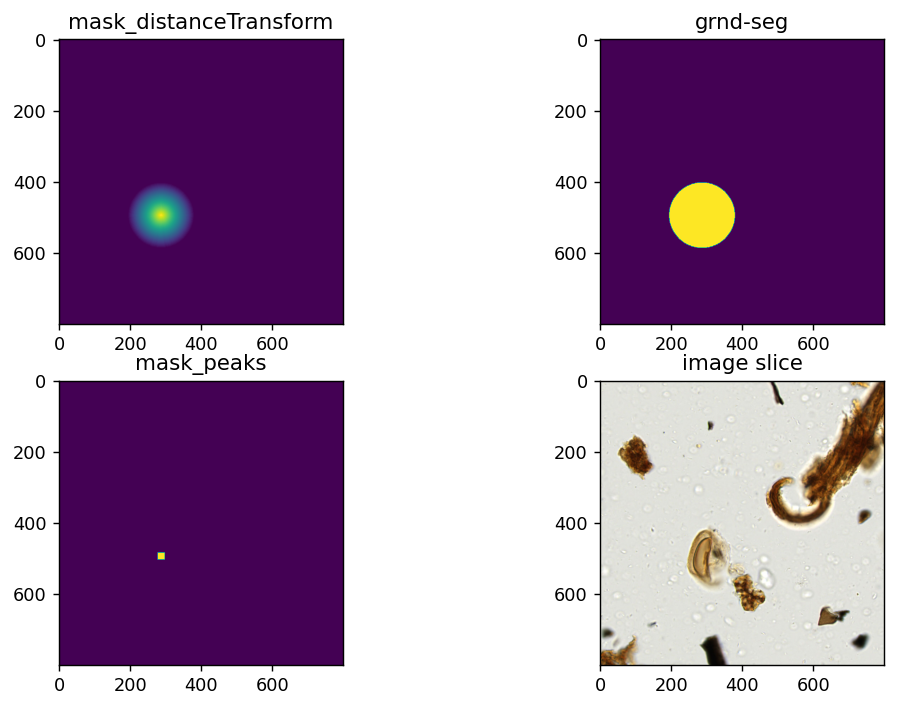

In [14]:
idx = 2

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10, 10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_distanceTransform[idx].squeeze().cpu().detach().numpy()  #.transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('mask_distanceTransform')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = label[idx].squeeze().cpu().detach().numpy()  #.transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('grnd-seg')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_peaks[idx].squeeze().cpu().detach().numpy()  #.transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('mask_peaks')

i=[0,3,6,9,12,15,18,21,24]
j=[3,6,9,12,15,18,21,24,27]
idx2=3
image_slice = image[:, int(i[idx2]):int(j[idx2]),: ,:]

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image_slice[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('image slice')


In [15]:
################## init model ###################
initModel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
initModel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
initModel = initModel.to(device);

# # print(initModel.encoder.encoder)

In [16]:
# loss for regression with masking
class MaskWeightedL1(nn.Module):
    def __init__(self, wBG=0.5, wFactor=1):
        super(MaskWeightedL1, self).__init__()        
        self.wBG = wBG
        self.wFactor = wFactor 
        
    def forward(self, inputs, target, segMask, overlapMask): 
        N, C, H, W = inputs.shape    #if mask only has 1 channel, C=1
        output = inputs - target
        totalNum = H * W * N
        output = torch.abs(output)
        output = torch.mean(output, 1, keepdim=True)
                
        output = output * (segMask + self.wBG) * (1-overlapMask)
        
        lossValue = output.sum() / totalNum
        return lossValue*self.wFactor

In [17]:
# loss for (binary) segmentation
weight = torch.ones(2)
weight[0] = 0.5
weight = weight.to(device)
#lossFunc_seg = nn.CrossEntropyLoss(weight=weight, reduction='elementwise_mean')
lossFunc_seg = nn.BCELoss(reduction='mean')

# loss for regression with masking
lossFunc_reg = MaskWeightedL1(wBG=weight_background, wFactor=weight_reg)

In [18]:
optimizer = optim.Adam([{'params': initModel.encoder.parameters()},
                        {'params': initModel.decoder.parameters()}], 
                       lr=base_lr, weight_decay=0.0005) 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=int(total_epoch_num/4), gamma=0.4)

# if training for the first time

In [19]:
# ################# start training ###################
# fn = open(log_filename,'w')
# fn.write(log_filename+'\t'+device+'\n\n')
# #fn.write(path.basename(__file__)+'\n\n')
# fn.close()
# file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
# fn = open(file_to_note_bestModel, 'w')
# fn.write('Record of best models on the way.\n')
# fn.close()

# Load the parameters from the generalized model

In [20]:
# # generalizedModel_dir = '/content/gdrive/MyDrive/exp/final/generalizedDet_2022_09_05'
# generalizedModel_dir = '/content/gdrive/MyDrive/exp/final/generalizedDet_2022_10_18'

# checkpoint = torch.load(path.join(generalizedModel_dir, 'bestValModel.pt'))
# initModel.load_state_dict(checkpoint['model'])
# epoch = 0
# initModel.to(device) 
# initModel.train(); # must be used when loading a checkpoint

In [22]:
# OR if model freezes during training, load the last checkpoint. 

# generalizedModel_dir = '/content/gdrive/MyDrive/exp/final/generalizedDet_2022_09_05'
# generalizedModel_dir = '/content/gdrive/MyDrive/exp/final/generalizedDet_2022_10_18'

checkpoint = torch.load(path.join(save_dir, 'bestValModel_1.pt'))
initModel.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch'] +1
# epoch = 89
best_loss = 0.041962 # use best loss of previous training
initModel.to(device) 
initModel.train(); # must be used when loading a checkpoint

In [23]:
print(epoch)
# print(best_loss)

90


In [24]:
################## start training ###################
# make sure to change log filename, file to note best model if you don't want the previous one overwritten

# fn = open(log_filename,'w')
# fn.write(log_filename+'\t'+device+'\n\n')
# #fn.write(path.basename(__file__)+'\n\n')
# fn.close()
# file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
# fn = open(file_to_note_bestModel, 'w')
# fn.write('Record of best models on the way.\n')
# fn.close()

# train model

In [ ]:
model_ft = train_model(initModel, dataloaders, 
                       lossFunc_seg, lossFunc_reg, 
                       optimizer, exp_lr_scheduler,
          
                       scaleList=scaleList, 
                       start_epoch=89,
                       num_epochs=total_epoch_num, 
                       work_dir=save_dir, 
                       device=device,
                       freqShow=freqShow)


Epoch 90/120
----------
train
	50/180 seg:0.024, reg:0.007
4m 29s
	100/180 seg:0.026, reg:0.007
3m 58s
	150/180 seg:0.026, reg:0.007
3m 56s
	loss: 0.034483
test
	loss: 0.043918

Epoch 91/120
----------
train
	50/180 seg:0.024, reg:0.006
1m 13s
	100/180 seg:0.026, reg:0.007
1m 17s
	150/180 seg:0.026, reg:0.007
1m 12s
	loss: 0.033024
test
	loss: 0.048566

Epoch 92/120
----------
train
	50/180 seg:0.029, reg:0.007
1m 14s
	100/180 seg:0.028, reg:0.008
1m 11s
	150/180 seg:0.027, reg:0.007
1m 15s
	loss: 0.034280
test
	loss: 0.048686

Epoch 93/120
----------
train
	50/180 seg:0.026, reg:0.007
1m 16s
	100/180 seg:0.027, reg:0.008
1m 17s
	150/180 seg:0.027, reg:0.007
1m 12s
	loss: 0.033025
test
	loss: 0.048871

Epoch 94/120
----------
train
	50/180 seg:0.029, reg:0.008
1m 13s
	100/180 seg:0.026, reg:0.008
1m 13s
	150/180 seg:0.027, reg:0.007
1m 12s
	loss: 0.034847
test
	loss: 0.043985

Epoch 95/120
----------
train
	50/180 seg:0.025, reg:0.007
1m 16s
	100/180 seg:0.027, reg:0.008
1m 13s
	150/1